In [259]:
import json
import requests
import urllib

# 0. Preliminary step to get sample data



This preliminary step is reproducing Lorella's workflow Python file:
https://i-lab.public.data.uu.nl/vault-ocex/ChroniclItaly%20-%20Italian%20American%20newspapers%20corpus%20from%201898%20to%201920%5B1529330521%5D/original/
I just added a folder "data_1" to keep all files in one folder

In [135]:
# create directory to then manually upload files from notebook env to this folder
# (would be better to get them from github or server, I'll take care of that when I get back)
mkdir 'data_files'

In [139]:
# files must first be manually uploaded into the data_files folder
files_list = os.listdir("data_files/")

# 1. Data preparation

## 1.1. Creating data frame
A dataframe is first created to keep the documents at their initial state, and the name of each file

In [260]:
import os
import pandas as pd

In [261]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [262]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open('data_files/' + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [263]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

In [264]:
# variable containing the documents separately
corpus = sources['file_content']

## 1.2 Removing stop words, punctuation, short words

In [265]:
%%capture
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [292]:
# add tokenized documents in dataframe
sources['tokens'] = sources['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [293]:
# possible user options:
# .isalnum() to removes tokens that include numbers
# .isalpha() to removes all tokens that contain more than letters (punctuation and numbers)
# .isdecimal() to remove tokens that contain only decimals
# .isdigit() to remove tokens that contain only digits

# add new column in df with processed tokens (here: keeping only alpha tokens longer than 3 characters + lowercasing)
sources['doc_prep'] = sources['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalpha() and len(w) > 2 )])

In [294]:
from nltk.corpus import stopwords
ital_stopwords = stopwords.words('italian')
en_stopwords = stopwords.words('english')

In [295]:
stop_words = pd.read_csv('stop_words.csv')

In [296]:
stopwords = stop_words['stopword'].values.tolist()

In [297]:
stopwords.extend(en_stopwords)

In [ ]:
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [299]:
# add column with tokenized documents without sw
sources['doc_prep_nostop'] = sources['doc_prep'].apply(lambda x: [w for w in x if not w in stopwords])

In [300]:
sources['doc_prep_nostop']

0       [alìito, first, italian, paper, pacific, coast...
1       [antto, subscription, rates, pavasle, advance,...
2       [xil, first, italian, pape, pacific, coast, co...
3       [normale, italiano, first, italian, paper, pac...
4       [umanità, fimi, italian, daiiy, onthi, pacific...
                              ...                        
3538    [xiv, first, paper, paci, coat, almama, patriz...
3539    [vecchio, qwthini, mmo, wowst, socio, permeine...
3540    [anito, xvi, first, iìalian, paper, paci, tic,...
3541    [pai, vecchio, pirpeleo, benemerita, balta, dm...
3542    [vecchio, ottatidane, itafiano, dctoveat, soda...
Name: doc_prep_nostop, Length: 3543, dtype: object

In [304]:
corpus_model = sources['doc_prep_nostop']

## 1.4 Lemmatize

In [ ]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [175]:
%%capture
!python -m spacy download it_core_news_sm

In [176]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [177]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [178]:
# takes a long time to run
# add column with lemmatized tokens - directly from the tokens as preprocessing has already been done
sources['doc_lemmatized'] = sources['doc_prep_nostop'].apply(lambda x: lemmatize(x))

In [179]:
# variable with lemmatized tokens
lemmatized_corpus = sources['doc_lemmatized']

# 2. Topics with LDA

In [302]:
#Gensim installation
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA



### 2.1.1 Bag of words

In [305]:
# dataset = [d.split() for d in lemmatized_corpus] (this is not useful if lemmatized version is used)
# Create Dictionary
# change "lemmatized_corpus" variable by stemmed_corpus or tokenized_corpus_without_sw depending
# on which version you would like to work with 
id2word = corpora.Dictionary(corpus_model)
corpus = [id2word.doc2bow(text) for text in corpus_model]

In [23]:
# list of words and occurence per document
#words = []
#frequency = []

#for cp in corpus:
#  word_id = list(cp[0])[0]
#  words.append(id2word[list(cp[0])[0]])
#  frequency.append(list(cp[0])[1])

In [24]:
# words_frequency = pd.DataFrame(list(zip(words, frequency)), columns=['word', 'frequency'])

In [ ]:
# sort descending
# words_frequency.sort_values(by=['frequency'], ascending=False)[:10]

## 2.2 LDA

In [306]:
# set the number of topics here
numtopics = 8

In [307]:
ldagensim = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics, chunksize = 2000, iterations = 100, passes = 20, eval_every = None)
# setting iterations to a larger number might provide better results

In [308]:
ldagensim.print_topics()

[(0,
  '0.001*"olio" + 0.001*"italia" + 0.001*"italiano" + 0.001*"giornale" + 0.001*"colonna" + 0.001*"telegrafico" + 0.001*"vivo" + 0.001*"dio" + 0.001*"milano" + 0.001*"newspaper"'),
 (1,
  '0.000*"azev" + 0.000*"labori" + 0.000*"trepof" + 0.000*"pablo" + 0.000*"collettivismo" + 0.000*"votino" + 0.000*"caravana" + 0.000*"patriotismo" + 0.000*"junk" + 0.000*"comunismo"'),
 (2,
  '0.005*"dispaccio" + 0.005*"telegrafico" + 0.004*"italia" + 0.003*"guerra" + 0.003*"uniti" + 0.003*"giornale" + 0.002*"italiano" + 0.002*"washington" + 0.002*"spagna" + 0.002*"roma"'),
 (3,
  '0.001*"nemico" + 0.001*"giapponesi" + 0.001*"guerra" + 0.001*"messico" + 0.001*"russi" + 0.001*"wilson" + 0.001*"tedeschi" + 0.001*"fronte" + 0.001*"arthur" + 0.001*"alleati"'),
 (4,
  '0.002*"colonna" + 0.001*"pagina" + 0.001*"olio" + 0.001*"carducci" + 0.001*"vivo" + 0.000*"razza" + 0.000*"lotti" + 0.000*"terremoto" + 0.000*"disastro" + 0.000*"cosmopolita"'),
 (5,
  '0.005*"italia" + 0.003*"italiano" + 0.003*"roma" + 0

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [309]:
from gensim.models.coherencemodel import CoherenceModel

In [311]:
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=corpus_model, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()
print('\nCoherence Score LDA Gensim: ', coherence_ldagensim)


Coherence Score LDA Gensim:  0.5018823081630367


## 2.4 Coherence and number of topics

In [ ]:
# as coherence calculation takes a very long time to run (around 45min with lowest accuracy), I removed the accuracy parameters for performance reasons 
# it's normal that the coherence is then lower than what was found earlier, as the parameters
# give less accurate results

In [312]:
%%capture
topics_nr = []
coherence_values_gensim = []
for num_topics in range(3, 20):
  model = models.LdaModel(corpus, id2word=id2word, num_topics=num_topics)
  coherencemodel = CoherenceModel(model=model, texts=corpus_model, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_gensim.append(coherence_value)
  topics_nr.append(str(num_topics))

In [313]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_gensim[i],4))

Num Topics = 3  has Coherence Value of 0.4125
Num Topics = 4  has Coherence Value of 0.4089
Num Topics = 5  has Coherence Value of 0.4168
Num Topics = 6  has Coherence Value of 0.412
Num Topics = 7  has Coherence Value of 0.4014
Num Topics = 8  has Coherence Value of 0.4098
Num Topics = 9  has Coherence Value of 0.4135
Num Topics = 10  has Coherence Value of 0.4037
Num Topics = 11  has Coherence Value of 0.4064
Num Topics = 12  has Coherence Value of 0.4084
Num Topics = 13  has Coherence Value of 0.4055
Num Topics = 14  has Coherence Value of 0.3966
Num Topics = 15  has Coherence Value of 0.4274
Num Topics = 16  has Coherence Value of 0.4001
Num Topics = 17  has Coherence Value of 0.3966
Num Topics = 18  has Coherence Value of 0.3989
Num Topics = 19  has Coherence Value of 0.4062


In [314]:
# Visualize coherence scores
import matplotlib.pyplot as plt

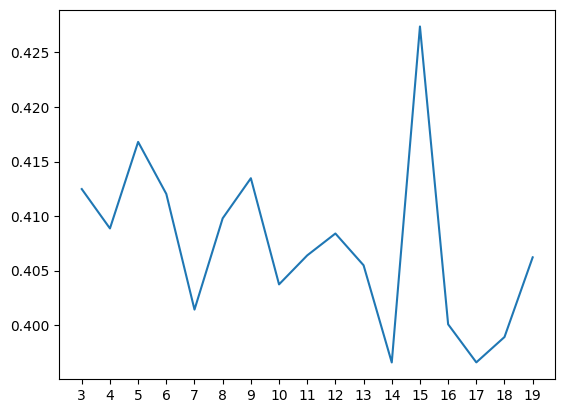

In [315]:
plt.plot(topics_nr, coherence_values_gensim)

In [ ]:
# To analyse the results, the user can print the list of topics for different topic nr

In [316]:
# print topics for nr of topics = 15 - I put here parameters for better accuracy as this will be 
# the model used to do the rest of calculations - takes approx 15min to run
%%capture
numtopics = 15
model = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics, iterations = 400, chunksize = 2000, passes = 20)

In [317]:
model.print_topics()

[(0,
  '0.006*"italia" + 0.005*"pagina" + 0.004*"york" + 0.003*"roma" + 0.003*"colonna" + 0.003*"francese" + 0.003*"italiano" + 0.003*"americana" + 0.003*"giornale" + 0.002*"francisco"'),
 (1,
  '0.004*"guerra" + 0.003*"libertà" + 0.002*"diritto" + 0.002*"legge" + 0.002*"compagni" + 0.002*"rivoluzione" + 0.002*"lavoratori" + 0.002*"patria" + 0.002*"popolo" + 0.002*"repubblica"'),
 (2,
  '0.001*"alaska" + 0.001*"minatori" + 0.001*"mafia" + 0.001*"yukon" + 0.001*"dally" + 0.001*"crawford" + 0.001*"dawson" + 0.001*"city" + 0.000*"humbert" + 0.000*"year"'),
 (3,
  '0.004*"italia" + 0.003*"italiano" + 0.003*"roma" + 0.002*"italiana" + 0.002*"italiani" + 0.002*"dispaccio" + 0.002*"guerra" + 0.002*"giornale" + 0.002*"giapponesi" + 0.002*"russia"'),
 (4,
  '0.004*"italia" + 0.003*"guerra" + 0.003*"roma" + 0.003*"presidente" + 0.003*"italiano" + 0.002*"dispaccio" + 0.002*"giornale" + 0.002*"uniti" + 0.002*"telegrafico" + 0.002*"washington"'),
 (5,
  '0.001*"fuora" + 0.001*"biasio" + 0.000*"coba

# Topic visualisation

## Data Preparation

In [318]:
%%capture
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/jscode-test-2.js
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_data_prepare_gensim.py

In [319]:
import csv

In [208]:
%%capture
!pip install funcy

In [320]:
%run -i tm1_data_prepare_gensim

<Figure size 640x480 with 0 Axes>

In [321]:
data_vis = prepare(model, corpus, id2word, doc_topic_dist=None)

In [322]:
topic_info = data_vis[1][data_vis[1]['Category'] == 'Default'].copy()

In [323]:
topic_info['relevance'] = ''

In [324]:
for i in range(numtopics):
  topic_num = i+1
  data = data_vis.sorted_terms(topic=topic_num, _lambda=.6).copy()
  topic_info = topic_info.append(data)

In [134]:
# uncomment to show the full output of a topic, replace 'Topic8' by the topic to display
# topic_info[topic_info['Category'] == 'Topic8']

In [325]:
topic_info.to_csv('topic_info.csv')

In [326]:
topic_proportion = data_vis[0].copy()

In [327]:
topic_proportion['proportion'] = topic_proportion['Freq'] / 100

In [328]:
topic_proportion.index.name = 'topic_id'

In [329]:
topic_proportion.to_csv('topic_proportion.csv')

In [330]:
%%capture
import notebook.nbextensions
notebook.nbextensions.install_nbextension('topic_info.csv', user=True)
notebook.nbextensions.install_nbextension('topic_proportion.csv', user=True)

## Visualisation

In [331]:
from IPython.display import display, HTML
from IPython.core.display import Javascript

In [332]:
display(HTML('<style>@import url("https://fonts.googleapis.com/css2?family=Fira+Sans:wght@300&display=swap");#vis_tm_1{width:40%; margin-left:20%}.svg-container{position:relative;width:100%;vertical-align:top;overflow:hidden;margin:0;padding:0;}.svg-content-responsive{margin:0;padding:0;display:inline-block;position:absolute;top:0;left:0}.line_style{stroke:"rgb(70, 130, 180,.3)";stroke-width:1}.svg_h1{font-size:.9em}.svg_h1,.svg_h2{font-family:"Fira Sans",Arial}.svg_h2{font-size:.6em}.svg_text{font-size:.8em}.svg_text,.svg_text_2{font-family:"Fira Sans",Arial}.svg_text_2{font-size:.7em}.svg_text_3{font-family:"Fira Sans";font-size:.6em}.select_box{width:30%;padding-left:1em;font-family:"Fira Sans",Arial}.select_box select{width:100%;background-color:#fff;padding:.5em .6em;box-shadow:inset 0 1px 3px #ddd;vertical-align:middle;font-family:"Fira Sans",Arial,sans-serif;letter-spacing:.01em;line-height:1.15;-webkit-writing-mode:horizontal-tb!important;text-rendering:auto;color:#000;letter-spacing:normal;word-spacing:normal;text-transform:none;text-indent:0;text-shadow:none;display:inline-block;text-align:start;-webkit-appearance:menulist;align-items:center;white-space:pre;-webkit-rtl-ordering:logical;background-color:#f8f8f8;cursor:default;margin:0;font:400 11px system-ui;border-radius:5px;border:1px solid #a6a6a6;border-image:none;border-image:initial}.select_box select:focus{border-color:#fff;outline:0;box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 1px rgba(102,175,233,.2)}</style>'))
display(HTML('<div id="vis_tm_1"></div>'))
Javascript(filename='jscode-test-2.js')

<IPython.core.display.Javascript object>

# Topic distribution

## 3.1. Distribution per topic and per document

In [333]:
%%capture
ldamodel = model

In [334]:
doc_topic_weights = ldamodel.inference(corpus)[0]
doc_topic_dists = doc_topic_weights / doc_topic_weights.sum(axis=1)[:, None]

In [335]:
distribution_gensim = pd.DataFrame(doc_topic_dists,columns=[f'topic{i}' for i in range(numtopics)])

In [336]:
distribution_gensim.index.name = 'document'

In [337]:
# add file names
distribution_gensim_wfiles = distribution_gensim.copy()
distribution_gensim_wfiles.insert(0, 'document_path', sources['file_name'])
distribution_gensim_wfiles

,document_path,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14
document,,,,,,,,,,,,,,,,
0,sn85066408_1898-06-16_ed-1_seq-1_ocr.txt,0.000050,0.016586,0.000050,0.592275,0.390542,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050
1,sn85066408_1897-06-22_ed-1_seq-1_ocr.txt,0.000057,0.026436,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,0.972828,0.000057,0.000057,0.000057,0.000057,0.000057
2,sn85066408_1898-04-06_ed-1_seq-1_ocr.txt,0.000081,0.000081,0.000081,0.000081,0.888016,0.000081,0.000081,0.061862,0.000081,0.049152,0.000081,0.000081,0.000081,0.000081,0.000081
3,sn85066408_1903-11-05_ed-1_seq-1_ocr.txt,0.094130,0.032582,0.147030,0.397038,0.000062,0.000062,0.000062,0.000062,0.000062,0.325762,0.000062,0.000062,0.000062,0.002905,0.000062
4,sn85066408_1904-04-18_ed-1_seq-1_ocr.txt,0.000048,0.000048,0.000048,0.445792,0.552842,0.000048,0.000048,0.000792,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3538,sn85066408_1900-12-06_ed-1_seq-1_ocr.txt,0.000058,0.083513,0.000058,0.000058,0.059912,0.000058,0.000058,0.001811,0.000058,0.854124,0.000058,0.000058,0.000058,0.000058,0.000058
3539,sn85066408_1906-11-30_ed-1_seq-1_ocr.txt,0.585236,0.000044,0.000044,0.066585,0.251024,0.000044,0.001922,0.000044,0.000044,0.091104,0.000044,0.000044,0.000754,0.000044,0.003021
3540,sn85066408_1902-10-09_ed-1_seq-1_ocr.txt,0.000041,0.117524,0.001340,0.114273,0.124836,0.000041,0.000041,0.001936,0.000041,0.639721,0.000041,0.000041,0.000041,0.000041,0.000041


## 3.2. Distribution per topic for the whole corpus

In [338]:
sources['doc_length'] = sources['doc_prep_nostop'].apply(lambda x: len(x))

In [339]:
topic_frequency = distribution_gensim.mul(sources['doc_length'], axis=0).sum()

In [340]:
topic_proportion = (topic_frequency / topic_frequency.sum()*100).sort_values(ascending=False)

In [341]:
topic_proportion

topic3     30.536252
topic9     19.035141
topic4     16.957668
topic1     13.667278
topic0     12.134461
topic6      3.826734
topic11     0.794001
topic14     0.688460
topic7      0.456442
topic13     0.419546
topic12     0.396052
topic2      0.369163
topic8      0.313757
topic10     0.227216
topic5      0.177829
dtype: float64

In [342]:
# dataframe with values to sort them by order of importance
distribution_df_gensim = pd.DataFrame(topic_proportion, columns=['weight'])

In [343]:
distribution_df_gensim.index.name = "topics"

In [344]:
topics = distribution_df_gensim.index.array

Text(0.5, 0, 'Weight (%)')

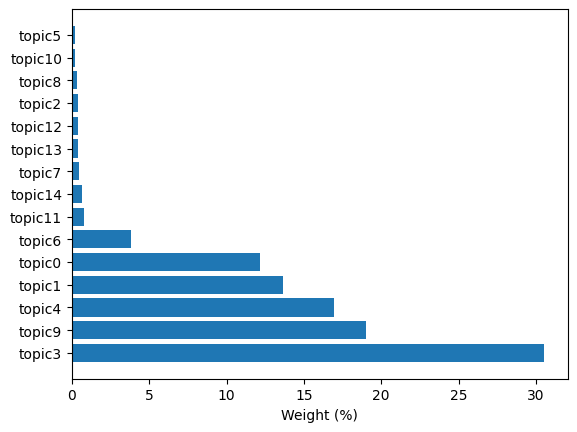

In [345]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(topics, distribution_df_gensim['weight'], align='center')
ax.set_xlabel('Weight (%)')

### 3.3. Distribution per publication


In [346]:
import re
import seaborn as sns

In [347]:
# function to retrieve publication ref from file name
def get_ref(file):
  ref_match = re.findall(r'(\w+\d+)_\d{4}-\d{2}-\d{2}_',file)
  return ref_match[0]

In [348]:
distribution_gensim_wfiles['publication'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_ref(x))

In [349]:
gensim_groupby2 = distribution_gensim_wfiles.copy()

In [350]:
distribution_title = gensim_groupby2.groupby(['publication']).mean().reset_index()

In [351]:
distribution_title

,publication,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14
0,2012271201,0.011102,0.806550,0.000335,0.081195,0.047693,0.00338,0.007652,0.005775,0.001966,0.010300,0.000695,0.000473,0.001157,0.018794,0.002932
1,sn85066408,0.112118,0.024263,0.005198,0.344869,0.192308,0.00163,0.038940,0.004455,0.003789,0.244753,0.002841,0.009924,0.004351,0.002220,0.008340


In [352]:
#restructuring df so that it can work with seaborn
df_vis2 = pd.DataFrame(columns=['publication', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_title.columns)-1
for i in range(len(distribution_title)):
  for j in range(columns_nr):
    df_vis2.loc[x] = ''
    df_vis2['publication'].loc[x] = distribution_title['publication'].loc[i]
    df_vis2['topic_id'].loc[x] = distribution_title.columns[j+1]
    df_vis2['distribution'].loc[x] = distribution_title.iloc[i,(j+1)]
    x+= 1

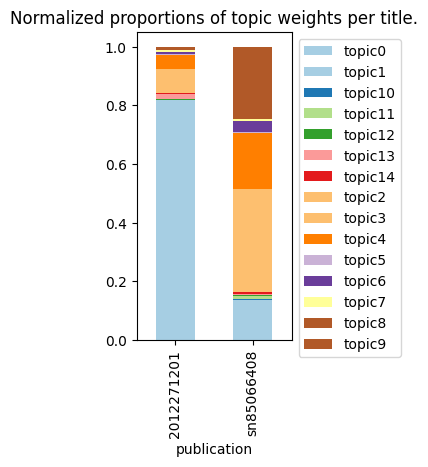

In [353]:
df_vis2.pivot('publication','topic_id', 'distribution')\
.plot(kind='bar', stacked=True, colormap='Paired', 
      figsize=(2,4), title='Normalized proportions of topic weights per title.')\
.legend(bbox_to_anchor=(1.75, 1))

# Topics weight over time

## 4.1 Aggregate document weights

In [354]:
# grouping data per month

In [355]:
# function to retrieve date from file name
def get_date(file):
  date_match = re.findall(r'_(\d{4}-\d{2}-\d{2})_',file)
  return date_match[0]

# function to retrieve year from file name
def get_year(file):
  year_match = re.findall(r'_(\d{4})-\d{2}-\d{2}_',file)
  return year_match[0]

# function to retrieve month from file name
def get_month(file):
  month_match = re.findall(r'_\d{4}-(\d{2})-\d{2}_',file)
  return month_match[0]

In [356]:
distribution_gensim_wfiles['date'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_date(x))
distribution_gensim_wfiles['year'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_year(x))
distribution_gensim_wfiles['month'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_month(x))

In [357]:
gensim_groupby = distribution_gensim_wfiles.copy()

In [358]:
# drop columns that won't be needed at this stage
gensim_groupby = gensim_groupby.drop(['document_path', 'date'], axis=1)

In [359]:
# group by year 
distribution_year = gensim_groupby.groupby(['year']).mean().reset_index()

In [360]:
distribution_year

,year,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14
0,1897,0.008191,0.034411,0.016366,0.372877,0.164566,0.000526,0.011047,0.003250,0.012540,0.332542,0.004427,0.012068,0.005615,0.003163,0.018411
1,1898,0.012568,0.030735,0.001759,0.129507,0.677639,0.001643,0.006023,0.007699,0.003653,0.102319,0.001085,0.003565,0.002436,0.000414,0.018957
2,1899,0.018665,0.023688,0.000157,0.119625,0.245225,0.021421,0.023683,0.023730,0.000384,0.387584,0.049584,0.000078,0.038326,0.014185,0.033666
3,1900,0.017859,0.031282,0.009174,0.327890,0.085209,0.001332,0.015305,0.005544,0.004609,0.480870,0.003195,0.000173,0.002230,0.002693,0.012635
4,1901,0.020084,0.032505,0.014437,0.156742,0.087543,0.000421,0.014036,0.001634,0.003892,0.658014,0.004191,0.000258,0.002420,0.003011,0.000812
5,1902,0.006957,0.021303,0.010502,0.289053,0.036745,0.000925,0.010465,0.002556,0.001986,0.611213,0.000611,0.001452,0.000591,0.001313,0.004330
6,1903,0.010936,0.084436,0.005131,0.431320,0.062250,0.000710,0.045824,0.008519,0.002255,0.326099,0.001969,0.001397,0.003302,0.007020,0.008831
7,1904,0.013622,0.125873,0.000436,0.608614,0.090171,0.002173,0.017785,0.002072,0.004520,0.075268,0.004563,0.041513,0.000585,0.008244,0.004563
8,1905,0.022736,0.136661,0.003719,0.274736,0.373001,0.002318,0.022376,0.001680,0.004016,0.135798,0.000566,0.011611,0.001103,0.006211,0.003468
9,1906,0.088041,0.144187,0.003149,0.209962,0.186521,0.002942,0.082143,0.004583,0.002821,0.229127,0.003625,0.002950,0.018651,0.007305,0.013994


## 4.2 Monthly average of normalized weight per topic

### 4.2.1. Line chart view 

In [370]:
#restructuring df so that it can work with seaborn
df_vis = pd.DataFrame(columns=['time', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_year.columns)-2
for i in range(len(distribution_year)):
  for j in range(columns_nr):
    df_vis.loc[x] = ''
    df_vis['time'].loc[x] = distribution_year['year'].loc[i]
    df_vis['topic_id'].loc[x] = distribution_year.columns[j+1]
    df_vis['distribution'].loc[x] = distribution_year.iloc[i,(j+1)]
    x+= 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


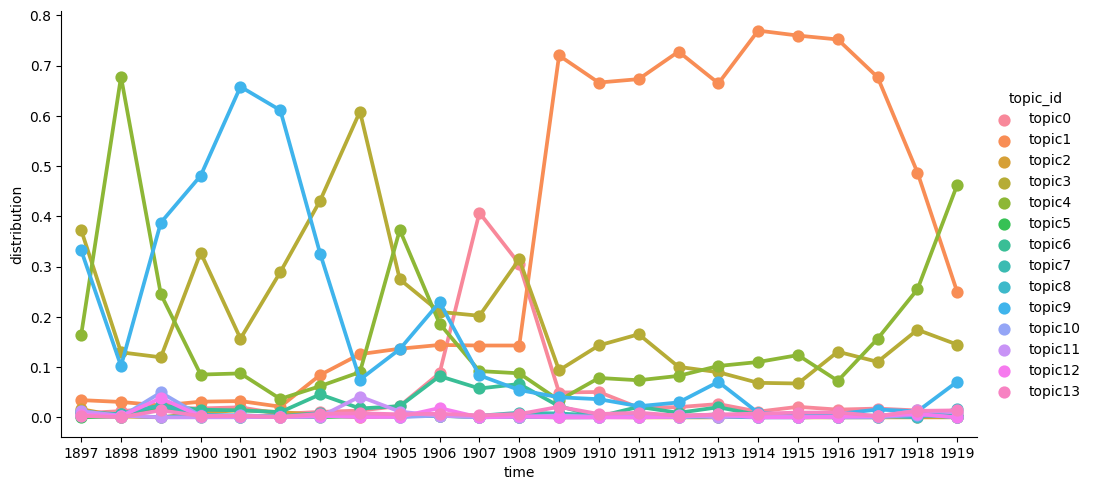

In [371]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.2. Bar chart view

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


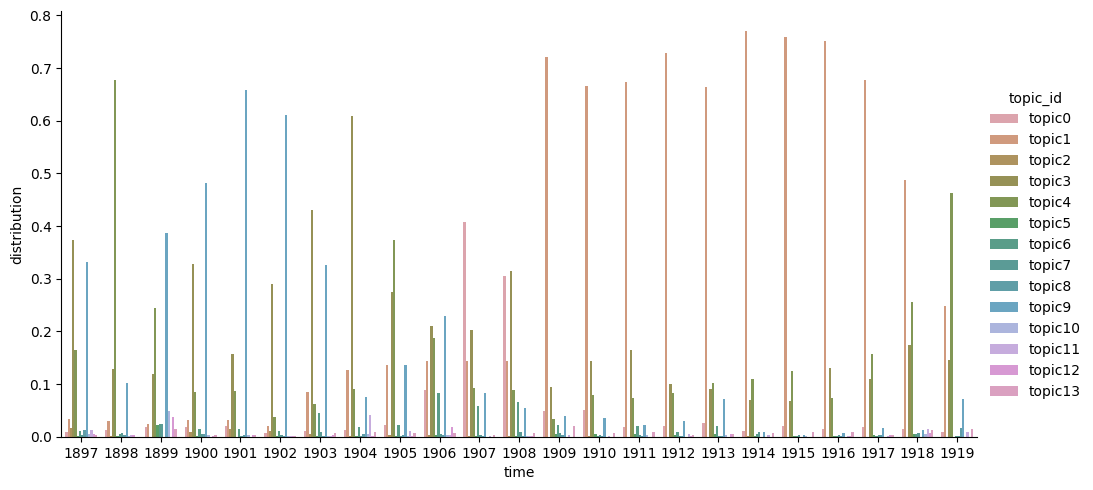

In [372]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               kind= 'bar',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.3. Topic weights per title over time



In [373]:
gensim_groupby3 = distribution_gensim_wfiles.copy()

In [374]:
distribution_title_time = gensim_groupby3.groupby(['year','publication']).mean().reset_index()

In [375]:
distribution_title_time

,year,publication,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14
0,1897,sn85066408,0.008191,0.034411,0.016366,0.372877,0.164566,0.000526,0.011047,0.003250,0.012540,0.332542,0.004427,0.012068,0.005615,0.003163,0.018411
1,1898,sn85066408,0.012568,0.030735,0.001759,0.129507,0.677639,0.001643,0.006023,0.007699,0.003653,0.102319,0.001085,0.003565,0.002436,0.000414,0.018957
2,1899,sn85066408,0.018665,0.023688,0.000157,0.119625,0.245225,0.021421,0.023683,0.023730,0.000384,0.387584,0.049584,0.000078,0.038326,0.014185,0.033666
3,1900,sn85066408,0.017859,0.031282,0.009174,0.327890,0.085209,0.001332,0.015305,0.005544,0.004609,0.480870,0.003195,0.000173,0.002230,0.002693,0.012635
4,1901,sn85066408,0.020084,0.032505,0.014437,0.156742,0.087543,0.000421,0.014036,0.001634,0.003892,0.658014,0.004191,0.000258,0.002420,0.003011,0.000812
5,1902,sn85066408,0.006957,0.021303,0.010502,0.289053,0.036745,0.000925,0.010465,0.002556,0.001986,0.611213,0.000611,0.001452,0.000591,0.001313,0.004330
6,1903,2012271201,0.003491,0.791707,0.000089,0.066555,0.023782,0.004166,0.017162,0.011992,0.000089,0.012349,0.000089,0.000089,0.002233,0.065848,0.000360
7,1903,sn85066408,0.011631,0.018425,0.005601,0.465365,0.065840,0.000387,0.048500,0.008195,0.002457,0.355383,0.002145,0.001520,0.003402,0.001529,0.009621
8,1904,2012271201,0.009305,0.808665,0.000169,0.080743,0.025636,0.003533,0.018657,0.000229,0.003408,0.003116,0.000091,0.000091,0.000091,0.042736,0.003529
9,1904,sn85066408,0.014358,0.009513,0.000481,0.698573,0.101168,0.001941,0.017637,0.002386,0.004709,0.087564,0.005325,0.048572,0.000669,0.002366,0.004739


### 4.2.4. Rolling average

In [377]:
rolling_mean = distribution_year.rolling(2).mean()

In [378]:
#restructuring df so that it can work with seaborn
df_vis3 = pd.DataFrame(columns=['time', 'topic_id', 'rolling_mean'])
x=0
columns_nr = len(rolling_mean.columns)-2
for i in range(len(rolling_mean)):
  for j in range(columns_nr):
    if ( rolling_mean.iloc[i,(j+1)] > 0 ):
      df_vis3.loc[x] = ''
      df_vis3['time'].loc[x] = distribution_year['year'].loc[i]
      df_vis3['topic_id'].loc[x] = rolling_mean.columns[j+1]
      df_vis3['rolling_mean'].loc[x] = rolling_mean.iloc[i,(j+1)]
      x+= 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


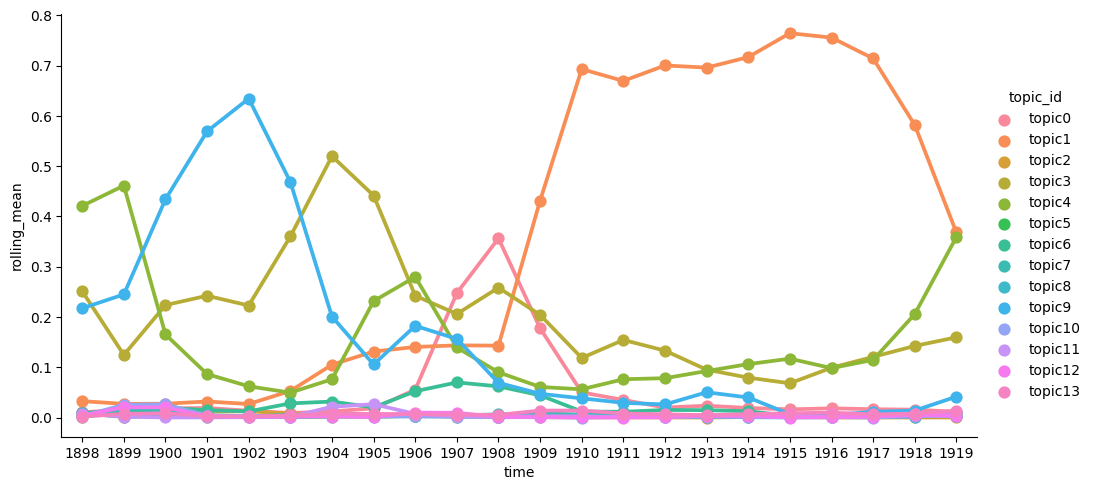

In [379]:
sns.factorplot(data= df_vis3, 
               x= 'time',
               y= 'rolling_mean',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)